**Оригинальный код**: https://www.kaggle.com/kueipo/simple-eda-geo-data-time-series

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy import stats

# Предсказание с помощью разложимой модели
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Операции с датой и временем
import time

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from fbprophet import Prophet
plt.style.use('fivethirtyeight')
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
start = time.time()
prop = pd.read_csv('drive/MyDrive/zillow-prize-1/properties_2016.csv')
train = pd.read_csv("drive/MyDrive/zillow-prize-1/train_2016_v2.csv", parse_dates=["transactiondate"])
df_train = train.merge(prop, how='left', on='parcelid')
end = time.time()
print("Время, потраченное на выполение этого скрипта {} сек.".format(end-start))

Время, потраченное на выполение этого скрипта 27.57416296005249 сек.


### Проверка использования памяти

Очень полезный навык, в том случае, если у нас досаточно ресурсов

In [4]:
# Устанавлиаем verbose равный False
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Columns: 3 entries, parcelid to transactiondate
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


In [5]:
prop.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 58 entries, parcelid to censustractandblock
dtypes: float64(52), int64(1), object(5)
memory usage: 1.3+ GB


In [6]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Columns: 60 entries, parcelid to censustractandblock
dtypes: datetime64[ns](1), float64(53), int64(1), object(5)
memory usage: 42.0+ MB


In [7]:
df_train.dtypes.value_counts()

float64           53
object             5
int64              1
datetime64[ns]     1
dtype: int64

In [8]:
del prop, train
gc.collect()

88

### Конвертация типа данных

In [9]:
for c, dtype in zip(df_train.columns, df_train.dtypes):
    if dtype == np.float64:
        df_train[c] = df_train[c].astype(np.float32) 
    elif dtype == np.int64:
        df_train[c] = df_train[c].astype(np.int32) 
gc.collect()

88

### DateTime Парсинг

In [10]:
df_train['transaction_month'] = df_train['transactiondate'].dt.month
df_train['transaction_year'] = df_train['transactiondate'].dt.year

## Однофакторный анализ

### Сфокусируемся на целевой переменной (**Log Error**)
- Фундаментальная статистика
- Визуализация распределения logerror

`logerror = log(Zestimate) - log(Saleprice)`

## Базовая статистика с применением Pandas и Numpy
-  **Pandas DataFrame/Numpy API**

`df.mean(), np.mean(df)`

In [11]:
me = np.mean(df_train['logerror']); med = np.median(df_train['logerror']); st = df_train['logerror'].std(); 
print(df_train['logerror'].describe())

count    90275.000000
mean         0.011458
std          0.161071
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64


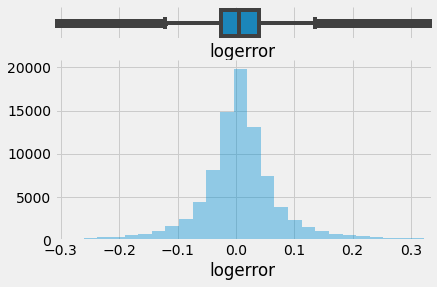

In [12]:
x = df_train['logerror']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlim([me-2*st, me+2*st])
plt.show()

#### Получаем скачки распределения близкие к нулю
- В Zillow очень хорошие Дата Сайентисты

# Многомерный анализ

## Распределние Целевой переменной с Fips by Bokeh

- Источник - 
[Philipp Spachtholz](https://www.kaggle.com/philippsp/exploratory-analysis-zillow) FanNotebook, we introduce **Absolute logerror** and **FIPS** codes map to city.



In [13]:
df_train.loc[:,'abs_logerror'] = df_train['logerror'].abs()

- Дата транзакции Vs ** Средняя Ошибка** в каждом регионе

In [14]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show

fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
fips3.reset_index(inplace = True)


output_notebook()
out = figure(plot_width=800, plot_height=250, x_axis_type="datetime")

for data, name, color in zip([fips1, fips2, fips3], ["Лос-Анджелес", "Регион Orange", "Регион Ventura"], Spectral4):

    out.line(data['transactiondate'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend=name)

out.legend.location = "top_left"
out.legend.click_policy="hide"
show(out)

- Год постройки Vs **Средняя Ошибка** в каждом регионе

In [15]:
#yearbuilt
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('yearbuilt')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('yearbuilt')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('yearbuilt')['abs_logerror'].mean())
fips3.reset_index(inplace = True)

output_notebook()
out = figure(plot_width=800, plot_height=250)

for data, name, color in zip([fips1, fips2, fips3], ["Лос-Анджелес", "Регион Orange", "Регион Ventura"], Spectral4):

    out.line(data['yearbuilt'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend=name)

out.legend.location = "top_right"
out.legend.click_policy="hide"
show(out)

### Важное замечание:  
- В регионе Ventura имеются **Шипы**, что означает, что оценка Zillow неточная

In [16]:
import plotly # visualization
from plotly.graph_objs import Scatter, Figure, Layout # visualization
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot # visualization
import plotly.figure_factory as ff # visualization
import plotly.graph_objs as go # visualization
init_notebook_mode(connected=True) # visualization

worst_prediction = df_train['abs_logerror'].quantile(q=.95)


trace0 = go.Scatter(
    y = df_train[(df_train['fips']==6037)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6037)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Los Angeles", 
)
trace1 = go.Scatter(
    y = df_train[(df_train['fips']==6059)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6059)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Orange County"
)
trace2 = go.Scatter(
    y = df_train[(df_train['fips']==6111)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6111)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Ventura County"
)
data = [trace0, trace1, trace2]

plotly.offline.iplot(data, filename='line-mode')

## 3.2 Георграфическое положение с помощью Folium и кластеризация с помощью KMeans

### Введение:

Folium сочетает в себе сильные стороны обработки данных экосистемы Python и сильные стороны отображения библиотеки Leaflet.js.

Вы можете обрабатывать свои данные в Python, а затем визуализировать их на карте Leaflet через Folium.

In [17]:
geo_df = df_train[['latitude', 'longitude','logerror']]

In [18]:
geo_df['longitude']/=1e6
geo_df['latitude']/=1e6

In [19]:
geo_df.dropna(subset=['latitude','longitude'], axis=0 ,inplace=True)

In [20]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=120, batch_size=1000).fit(geo_df[['latitude','longitude']])
geo_df.loc[:, 'label'] = kmeans.labels_

In [21]:
map_2 = folium.Map(location=[34.088537, -118.249923],
                   zoom_start=9)
for label in kmeans.cluster_centers_:
    folium.Marker(location=list([label][0])).add_to(map_2)

map_2

In [22]:
map_1 = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Terrain')
for label in kmeans.cluster_centers_:
    folium.Marker(location=list([label][0])).add_to(map_1)
map_1



In [23]:
del map_2 ,map_1
gc.collect()

32258

### Результат:
-  Большинство домов находится в **Flat Ground**
-  Небольшое количество домов находится в **Santa Catalina Island**

## 3.3 Где находится зона с идеальной оценкой ?

- Мы собираемся изучить этот вопрос, игнорируя Time Series, например, не беря в расчет месяц 

In [24]:
gc.collect()
perfect_geo_df = geo_df[geo_df['logerror']==0]
perfect_geo_df.shape

(847, 4)

In [25]:
map_perfect = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Toner')
for lat, lon in zip(perfect_geo_df.latitude, perfect_geo_df.longitude):
    folium.Marker(location=[lat,lon]).add_to(map_perfect)
map_perfect



In [26]:
del perfect_geo_df, map_perfect, geo_df
gc.collect()

88

### Важное замечание:
- Нет закономерности между географическим положением и идеальной оценкой
- Never Happen in the Santa Catalina Island (Millionair hard to predict :-) )

# Подход Временнных Рядов

##  Агрегация и визуализация

### Общая средняя абсолютная Log Error

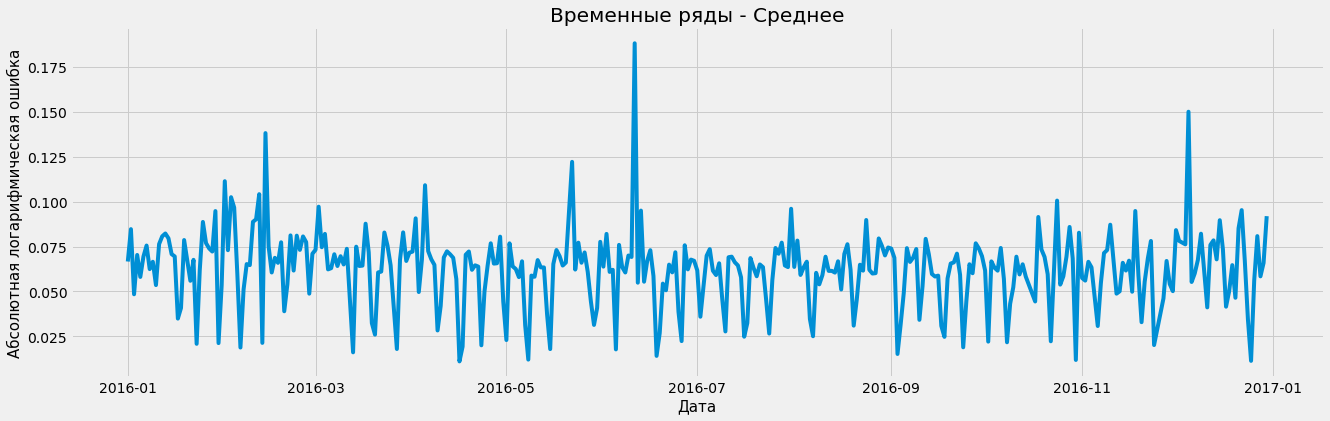

In [27]:
plt.figure(figsize=(20, 6))
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Абсолютная логарифмическая ошибка', fontsize=15)
plt.title('Временные ряды - Среднее')
plt.show()

### Средняя абсолютная логарифмическая ошибка по Лос-Анджелесу

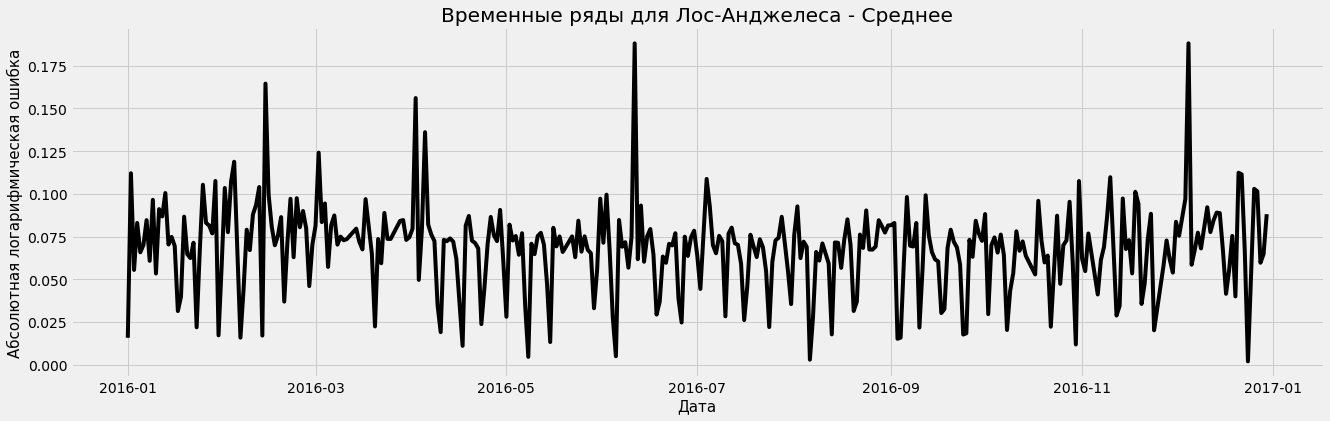

In [28]:
plt.figure(figsize=(20, 6)) 
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1,c='k')
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Абсолютная логарифмическая ошибка', fontsize=15)
plt.title('Временные ряды для Лос-Анджелеса - Среднее')
plt.show()

### Средняя абсолютная логарифмическая ошибка по Orange County

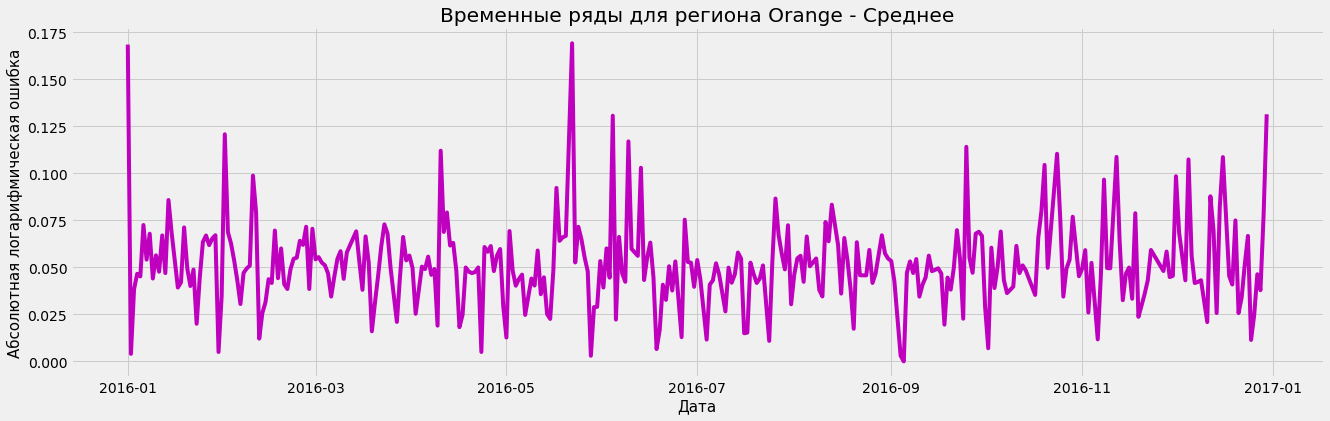

In [29]:
plt.figure(figsize=(20, 6)) 
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'm')
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Абсолютная логарифмическая ошибка', fontsize=15)
plt.title('Временные ряды для региона Orange - Среднее')
plt.show()

### Средняя абсолютная логарифмическая ошибка по Ventura County

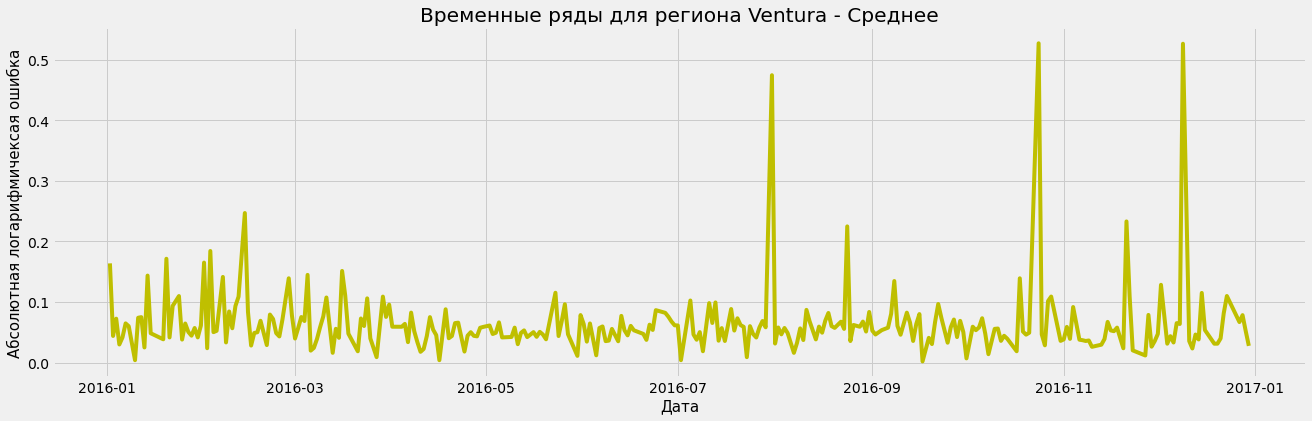

In [30]:
plt.figure(figsize=(20, 6))
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'y')
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Абсолютная логарифмичексая ошибка', fontsize=15)
plt.title('Временные ряды для региона Ventura - Среднее')
plt.show()

- Медианная абсолютная логарифмическая ошибка

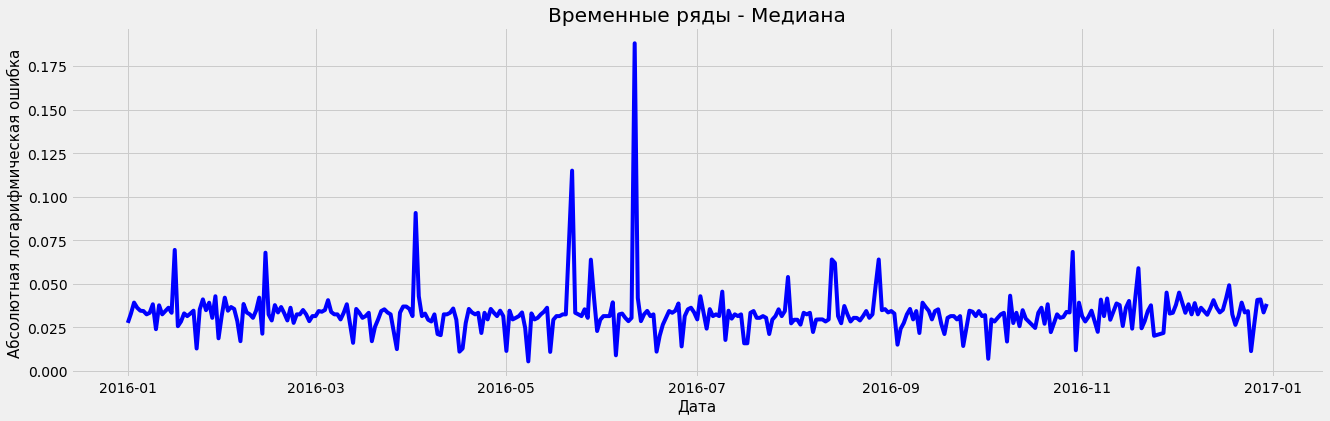

In [31]:
plt.figure(figsize=(20, 6))
median_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(median_group, c='b')
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Абсолютная логарифмическая ошибка', fontsize=15)
plt.title('Временные ряды - Медиана')
plt.show()

- Стандартное отлонение абсолютной логарифмической ошибки

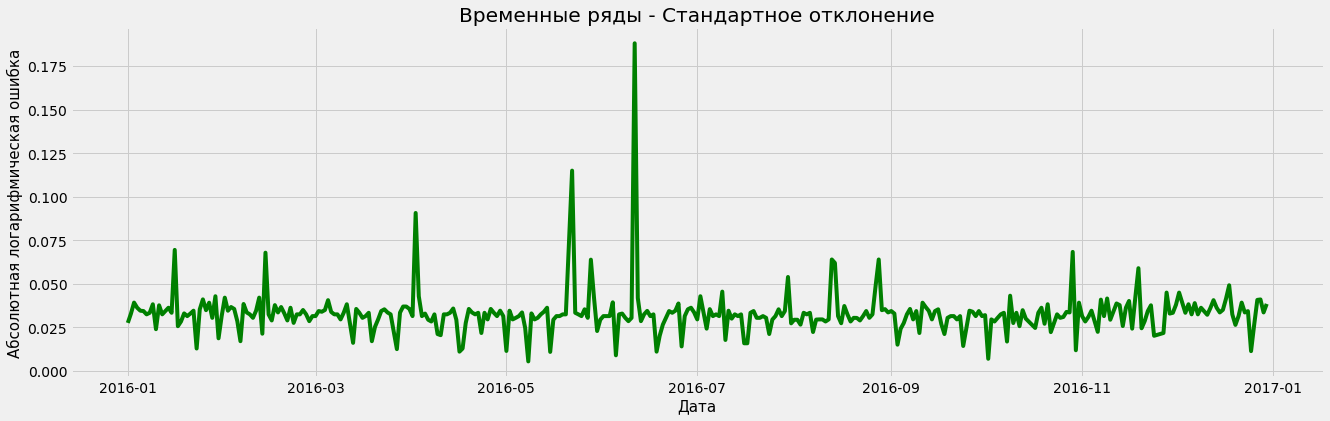

In [32]:
plt.figure(figsize=(20, 6))
std_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(std_group, c='g')
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Абсолютная логарифмическая ошибка', fontsize=15)
plt.title('Временные ряды - Стандартное отклонение')
plt.show()

In [33]:
del mean_group, median_group, std_group
gc.collect()

14623


Here, I only use inliner 
    - Definition:  Absolute Logerror < Mean + Std

In [34]:
df_train = df_train[df_train['abs_logerror']<  me + st ]
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()

### Компоненты Временнных рядов
  
- Данные временные ряды состоят из 3-х системных компонентов, включая уровень, тренд, сезонность, и один не системный компонент, называемый шумом. Эти компоненты могут быть определены, как:

    1. **Уровень**: Среднее значение в рядах.
    2. **Тренд**: Увеличение или уменьшение значения в рядах. 
    3. **Сезонность**: Повторение краткосрочного циклав рядах. 
    4. **Шум**: Случанйая вариация в рядах.




### Комбинирование компонентов временных рядов
- Временнные ряды являются агрегацией комбинацией этих четырех компонентов. Все временные ряды имеют уровень и шум. Тренд и сезонность являются необязательными компонентами. Компоненты могут комбинироваться **аддитивно** или **мультипликативно**.

    - Аддитивная модель
        y(t) = Уровень + Тренд + Сезонность + Шум 
        
    - Мультипликативная модель
        y(t) = Уровень x Тренд x Сезонность x Шум 



- Аддитивная модель

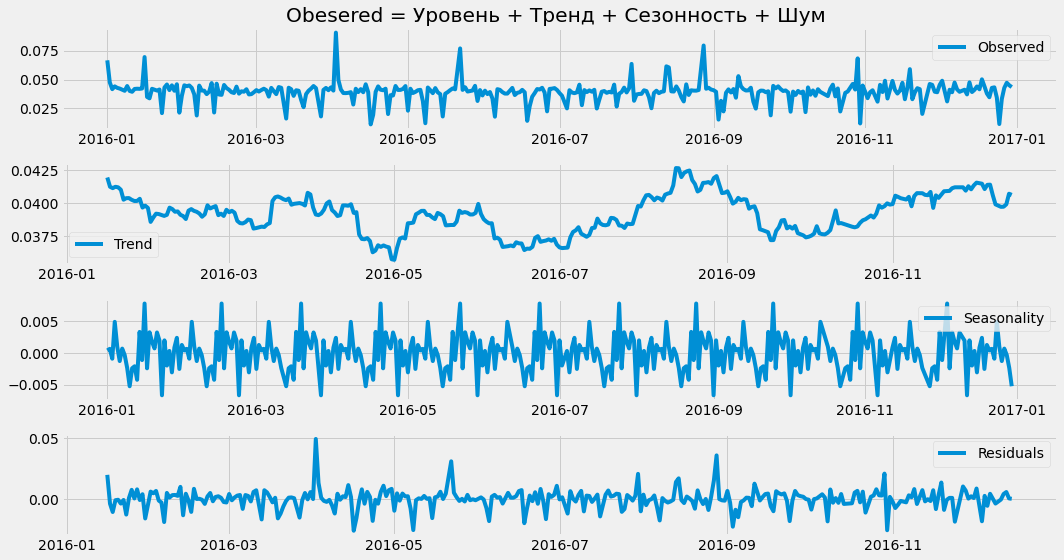

In [35]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='additive',freq = 31)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Уровень + Тренд + Сезонность + Шум ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- Мультипликативная модель

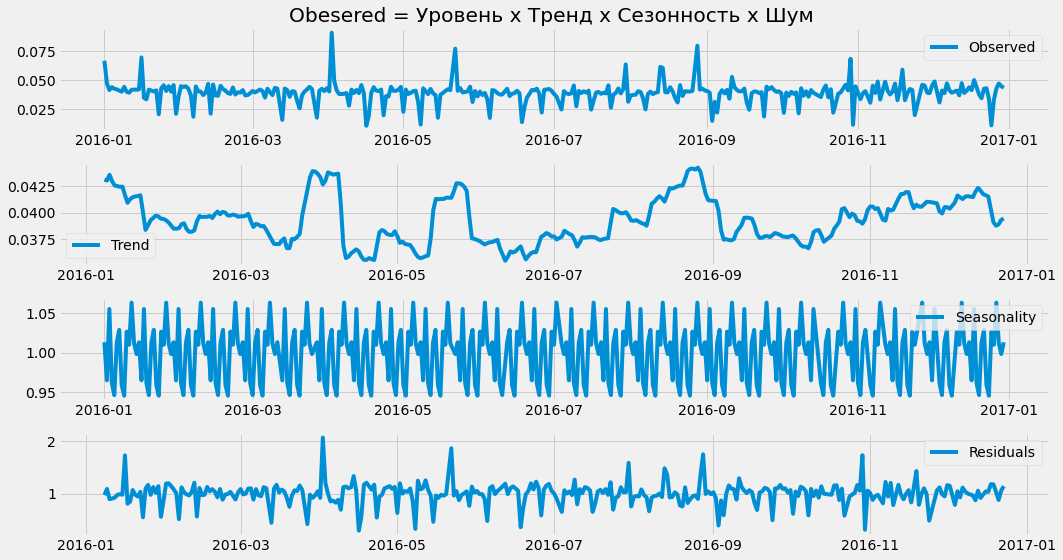

In [36]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 14)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Уровень x Тренд x Сезонность x Шум ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Скользящая средняя  / Random Walk and Stationarity

СКользящая средняя - это наивная и эффективная техника для предсказания времянных рядов. Она может быть использована для подготовки данных, и даже для прогнозирования.

Стационарный времянные ряды являются временными рядами, значения которых не зависят от времени. Мы можем подтвердить это, используя тест статистической значимости, в частности, расширенного теста Dickey-Fuller.

- The script is copied from kaggler 
    1. [Julien Heiduk](https://www.kaggle.com/zoupet) and  
    2. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ 
    3. [Dr. Jason Brownlee]()

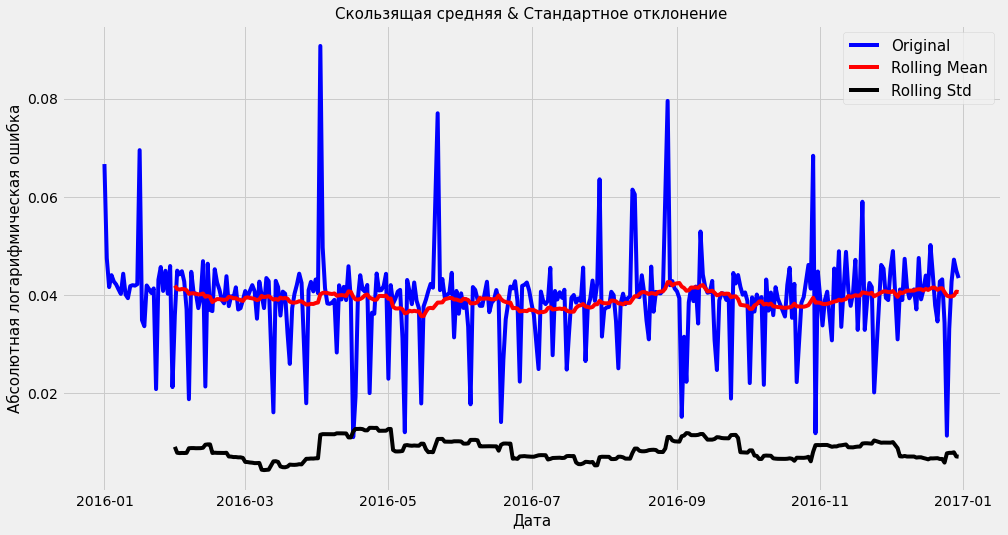

Результаты теста Dickey-Fuller:
Test Statistic                -1.736474e+01
p-value                        5.179029e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [37]:
def test_stationarity(timeseries):
    plt.figure(figsize=(15, 8))
    #Определение rolling statistics
    rolmean = timeseries.rolling(31).mean() # Slide window depend on past 1 month
    rolstd = timeseries.rolling(31).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=15)
    plt.title('Скользящая средняя & Стандартное отклонение', fontsize=15)
    plt.xlabel('Дата', fontsize=15)
    plt.ylabel('Абсолютная логарифмическая ошибка', fontsize=15)
    plt.show(block=False)
    
    #ВЫполнения теста Dickey-Fuller:
    print('Результаты теста Dickey-Fuller:')
    dftest = sm.tsa.adfuller(timeseries['abs_logerror'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   

**Нулевая гипотеза** теста заключается в том, что временные ряды являются не **стационарными** и мы можем увидеть, что статистическое значение теста было **-1.736474e+01** с уровнем значимости меньше **1%** (низкая вероятность того, что это статистичнеская случайность). 

Отказ от нулевой гипотезы означает, что процесс не имеет единичного корня и, в свою очередь, временной ряд является **стационарным** или не имеет зависящей от времени структуры.

# Структура, не зависящая от времени
- Ограничения 
    - Исключить отклоняющиеся значения
    - Зависит только от последних 3-х месяцев 

## Предсказание с помощью Prophet
### Вдохновлено [Julien Heiduk](https://www.kaggle.com/zoupet)

- Этот инструмент был разработан Facebook. Больше информации об этой библиотеке можно найти по ссылке: https://research.fb.com/prophet-forecasting-at-scale/



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 2160x432 with 0 Axes>

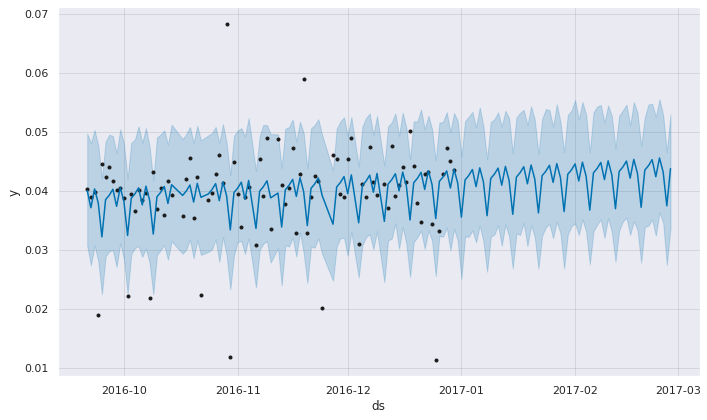

In [38]:
sns.set(font_scale=1) 
df_prophet =  pd.DataFrame(mean_group).reset_index(drop=False)
df_prophet = df_prophet.iloc[-92:,:] # Предсказание на основе последних 3 месяцев
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=59,freq='D') # Forecast Jan 2017
forecast = m.predict(future)
plt.figure(figsize=(30, 6))
fig = m.plot(forecast)
plt.show()